In [1]:
from numpy import pi as PI
from scipy.stats import skew, kurtosis
from scipy.integrate import quad
from scipy.spatial.distance import pdist, cdist, squareform

import scipy
import random
import pandas as pd
import numpy as np
import ringity as rng
import networkx as nx
import matplotlib.pyplot as plt

plt.style.use("fivethirtyeight")

In [2]:
def pdf_local_density(rho_i, a, rho, parameter, parameter_type):
    def costum_expected_node_degree(x):
        return rng.expected_node_degree(x, a=a, rho=rho, 
                                        parameter=parameter, parameter_type=parameter_type)
    def costum_d_expected_node_degree(x):
        return rng.d_expected_node_degree(x, a=a, rho=rho, 
                                          parameter=parameter, parameter_type=parameter_type)
    
    result = 0
    
    theta_max = rng.get_max_expectancy(a, parameter=beta, parameter_type=parameter_type)
    theta_min = rng.get_min_expectancy(a, parameter=beta, parameter_type=parameter_type)
    
    rho_max = costum_expected_node_degree(theta_max)
    rho_min = costum_expected_node_degree(theta_min)
    
    rho_left  = costum_expected_node_degree(0.)
    rho_right = costum_expected_node_degree(2*PI)
    
    
    if rho_left <= rho_i <= rho_max:
        theta = scipy.optimize.toms748(lambda x: costum_expected_node_degree(x)-rho_i, 
                                       0., theta_max)
        value = rng.pdf_delay(theta, parameter=parameter, parameter_type=parameter_type)
        result += value / abs(costum_d_expected_node_degree(theta))
        
    if rho_min <= rho_i <= rho_max:
        theta = scipy.optimize.toms748(lambda x: costum_expected_node_degree(x)-rho_i, 
                                       theta_max, theta_min)
        value = rng.pdf_delay(theta, parameter=parameter, parameter_type=parameter_type)
        result += value / abs(costum_d_expected_node_degree(theta))
        
    if rho_min <= rho_i <= rho_right:
        theta = scipy.optimize.toms748(lambda x: costum_expected_node_degree(x)-rho_i, 
                                       theta_min, 2*PI)
        value = rng.pdf_delay(theta, parameter=parameter, parameter_type=parameter_type)
        result += value / abs(costum_d_expected_node_degree(theta))
        
    return result

In [3]:
def simulated_local_density(a, rho, parameter, parameter_type):
    delays = rng.get_delays(N=2**17, param=parameter, parameter_type=parameter_type)
    return np.array([rng.expected_node_degree(theta, a=a, rho=rho, parameter=beta, parameter_type='delay')
                         for theta in delays])

In [4]:
def deg_distribution(k, N, a, rho, parameter, parameter_type):
    def costum_expected_node_degree(x):
        return rng.expected_node_degree(x, a=a, rho=rho, 
                                        parameter=parameter, parameter_type=parameter_type)
    
    theta_max = rng.get_max_expectancy(a, parameter=parameter, parameter_type=parameter_type)
    theta_min = rng.get_min_expectancy(a, parameter=parameter, parameter_type=parameter_type)
    
    rho_max = costum_expected_node_degree(theta_max)
    rho_min = costum_expected_node_degree(theta_min)
    
    return scipy.integrate.quad(lambda rho_i:
                                   pdf_local_density(rho_i, a=a, rho=rho, 
                                                   parameter=parameter, 
                                                   parameter_type = parameter_type) * \
                                   scipy.stats.poisson.pmf(k, (N-1)*rho_i),
                                rho_min,rho_max)[0]

In [5]:
N = 2**14

rho  = 0.046
beta = 0.573
a    = 0.191

# local density distribution

In [6]:
%%time

ensembl_size = 2**2

obs_rhos = []

for i in range(ensembl_size):
    print(f"{100*i/ensembl_size:.2f}%", end='\r')
    delas = rng.get_delays(N, beta)
    dists = rng.delays_to_distances(delas)
    simis = rng.distances_to_similarities(dists, a=a)
    probs = rng.similarities_to_probabilities(simis, a=a, rho=rho, param=beta, parameter_type = 'delay')
    degs = squareform(probs).mean(axis=0)

    obs_rhos.append(degs)

print("Average observed degree: " , np.mean(probs))
print("        Expected degree: " , rho)
print()
    
obs_rhos = np.array(obs_rhos).flatten()

KeyboardInterrupt: 

In [ ]:
sim_rhos = simulated_local_density(a=a, rho=rho, parameter=beta, parameter_type='delay')

In [ ]:
@np.vectorize
def costum_expected_node_degree(xi):
        return rng.expected_node_degree(xi, a=a, rho=rho, parameter=beta, parameter_type = 'delay')

@np.vectorize
def costum_d_expected_node_degree(xi):
        return rng.d_expected_node_degree(xi, a=a, rho=rho, parameter=beta, parameter_type = 'delay')

In [ ]:
x = np.linspace(0,2*PI,100)
y1 = costum_expected_node_degree(  x)
y2 = costum_d_expected_node_degree(x)

theta_max = rng.get_max_expectancy(a, parameter=beta, parameter_type='delay')
theta_min = rng.get_min_expectancy(a, parameter=beta, parameter_type='delay')

rho_max = costum_expected_node_degree(theta_max)
rho_min = costum_expected_node_degree(theta_min)

fig, ax = plt.subplots(figsize=(12,12))

ax.axhline(y=0, color='k')
ax.axvline(x=2*PI*a    , color='k')
ax.axvline(x=2*PI*(1-a), color='k')

ax.plot(x,y1)
ax.plot(x,y2)
ax.plot([theta_max, theta_max], [0,rho_max], 'o', markersize=15)
ax.plot([theta_min, theta_min], [0,rho_min], 'o', markersize=15)

In [10]:
annotation_str = fr"""$\rho = {rho:.3f}$
$\beta = {beta:.3f}$
$a = {a:.3f}$
$N = {N}$

#observed_nodes $= {ensembl_size}\cdot N={ensembl_size*N}$"""

/usr/local/lib/python3.7/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


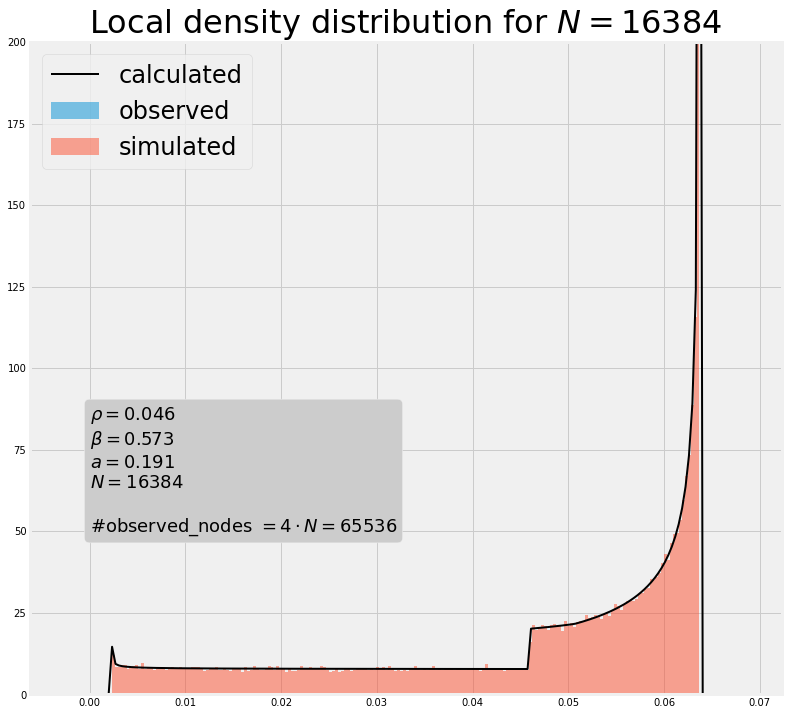

In [14]:
eps = 0.005
x = np.linspace(rho_min-eps, rho_max+eps,200)
y = [pdf_local_density(rho_i, a, rho, beta, parameter_type = 'delay') for rho_i in x]

fig, ax = plt.subplots(figsize=(12,12))

#ax.hist(obs_rhos, bins=200, density=True, label='observed' , alpha=0.5);
ax.hist([], bins=200, density=True, label='observed' , alpha=0.5);
ax.hist(sim_rhos, bins=200, density=True, label='simulated', alpha=0.5);
#ax.hist([], bins=200, density=True, label='simulated', alpha=0.5);
ax.plot(x, y, linewidth=2, label='calculated', c='k');
ax.set_ylim(0,200)
ax.set_title(f'Local density distribution for $N={N}$', fontsize=32)
ax.legend(fontsize=24)
ax.annotate(annotation_str, (0, 50), 
            fontsize=18, bbox=dict(boxstyle="round", fc="0.8"))
fig.savefig("/Users/markusyoussef/Desktop/ring_meeting/tmp.pdf")

# degree distribution

In [6]:
obs_degs = []
obs_weig = []

ensembl_size = 2**1

for i in range(ensembl_size):
    print(f"{100*i/ensembl_size:.2f}%", end='\r')
    delas = rng.get_delays(N, beta)
    dists = rng.delays_to_distances(delas)
    simis = rng.distances_to_similarities(dists, a=a)
    probs = rng.similarities_to_probabilities(simis, a=a, rho=rho, param=beta, parameter_type = 'delay')
    degs = squareform(probs > np.random.uniform(size=N*(N-1)//2)).sum(axis=0)

    obs_degs.append(degs)
#    obs_weig.append(probs)
        
print("Average observed degree: " , np.mean(degs))
print("        Expected degree: ", rho*N)
print()
    
obs_degs = np.array(obs_degs).flatten()
#obs_weig = np.array(obs_weig).flatten()

Average observed degree:  746.172119140625
        Expected degree:  753.664



In [7]:
exp_degs = np.array([scipy.stats.poisson.rvs((N-1)*rho_i) 
                         for rho_i in simulated_local_density(a=a, rho=rho, 
                                                              parameter=beta, parameter_type='delay')])

In [14]:
%%time

k = np.linspace(min((min(exp_degs), min(obs_degs))), 
                max((max(exp_degs), max(obs_degs))),
                50, dtype=int)

degs = [deg_distribution(ki, N, a, rho, parameter=beta, parameter_type='delay') for ki in k]

CPU times: user 1min 8s, sys: 357 ms, total: 1min 8s
Wall time: 1min 9s


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:17: IntegrationWarning: The integral is probably divergent, or slowly convergent.


In [15]:
annotation_str = fr"""$\rho = {rho:.3f}$
$\beta = {beta:.3f}$
$a = {a:.3f}$
$N = {N}$

#observed_nodes $= {ensembl_size}\cdot N={ensembl_size*N}$"""

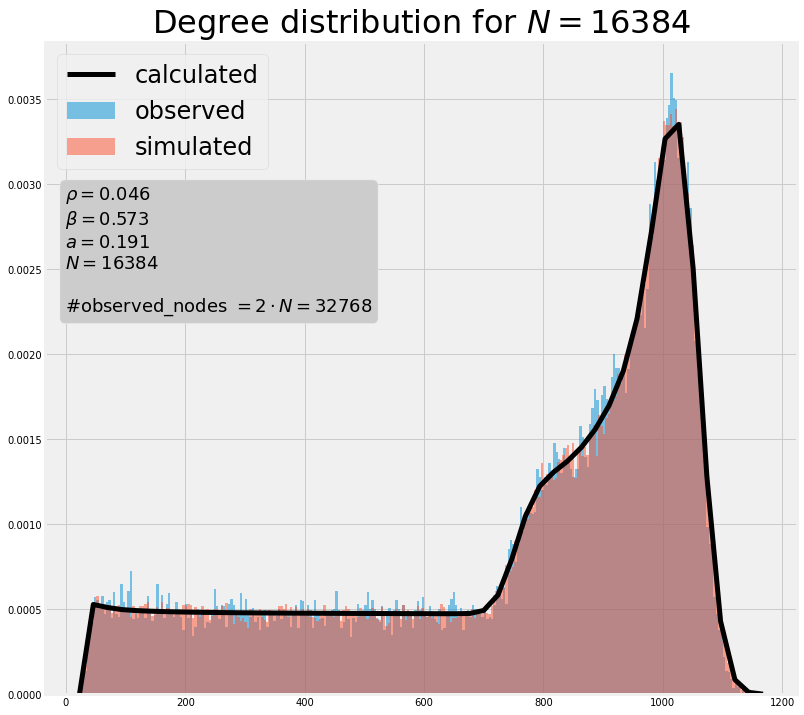

In [16]:
nb_bins_obs = (max(obs_degs)-min(obs_degs))
nb_bins_exp = (max(exp_degs)-min(exp_degs))

fig, ax = plt.subplots(figsize=(12,12))

ax.hist(obs_degs, bins=nb_bins_obs//4, density=True, alpha=0.5, label='observed');
ax.hist(exp_degs, bins=nb_bins_exp//4, density=True, alpha=0.5, label='simulated');
ax.plot(k, degs, linewidth=5, c='k', label='calculated')

ax.set_title(f'Degree distribution for $N={N}$', fontsize=32)
ax.legend(fontsize=24)

ax.annotate(annotation_str, (-1, 0.00225), 
            fontsize=18, bbox=dict(boxstyle="round", fc="0.8"))
fig.savefig("/Users/markusyoussef/Desktop/ring_meeting/tmp.pdf")